# Code to generate Figure 6 

In [1]:
from gz21_ocean_momentum.analysis.utils import plot_dataset, GlobalPlotter
import xarray as xr
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import numpy as np
import cmocean

To load the net from the paper, use the function load_paper_net().


## Steps
### Locate forcing data
* `forcings_ctrl_path` should point to forcing data generated using the control CM2.6 dataset.
* `forcings_1pct_path` should point to forcing data generated using the annual 1% CO2 increase CM2.6 dataset.

See the Jupyter notebook README and the example CLI configs for help selecting/generating these.

In [2]:
forcings_ctrl_path = "~/sh/gz21/tmp/generated/forcings/paper-fig-1-ctrl-n100"
forcings_1pct_path = "~/sh/gz21/tmp/generated/forcings/paper-n100"

### Various parameters

In [3]:
plt.rcParams["figure.figsize"] = (4, 4 / 1.618)
var_name = 'vsurf'

### The rest

In [4]:
data_control = xr.open_zarr(forcings_ctrl_path)
data_1pct    = xr.open_zarr(forcings_1pct_path)

data_control = data_control.rename(dict(xu_ocean='longitude', yu_ocean='latitude'))
data_1pct    = data_1pct.rename(dict(xu_ocean='longitude', yu_ocean='latitude'))

# Rescale the forcing
for var in ('S_x', 'S_y'):
    data_control[var] /= 1e-7
    data_1pct[var] /= 1e-7

# Remove the seasonal means
seasonal_groupby_control = data_control.groupby('time.month').mean()
seasonal_groupby_1pct = data_1pct.groupby('time.month').mean()

data_control = data_control.groupby('time.month') - seasonal_groupby_control
data_1pct = data_1pct.groupby('time.month') - seasonal_groupby_1pct

In [5]:
var_control = data_control[var_name].std(dim='time')
var_1pct = data_1pct[var_name].std(dim='time')
with ProgressBar():
    var_control = var_control.compute()
    var_1pct = var_1pct.compute()

[########################################] | 100% Completed | 3.64 sms
[                                        ] | 0% Completed | 458.18 us

/home/raehik/proj/work/2020-ukc-camfort-iccs/iccs/lib/gz21/venv/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 3.73 sms


In [6]:
diff =  var_1pct - var_control
r_diff = diff / var_control

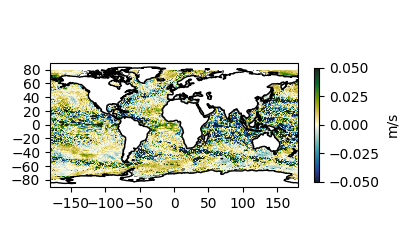

In [7]:
#%matplotlib notebook #this option does not work with jupyterlab
%matplotlib widget

plotter = GlobalPlotter(cbar=True, margin=4)
plotter.x_ticks = np.arange(-150., 151., 50)
plotter.y_ticks = np.arange(-80., 81., 20)

ax=plotter.plot(diff, vmin=-0.05, vmax=0.05, cmap=cmocean.cm.delta, lon=0., colorbar_label='m/s')

In [8]:
plt.savefig('r_diff_' + var_name + '.jpg', dpi=400)

In [9]:
uv_plotter = plotter
def apply_complete_mask(array):
    mask = uv_plotter.borders
    mask2 = uv_plotter.mask
    mask = mask.interp({k: array.coords[k] for k in ['longitude', 'latitude']})
    mask2 = mask2.interp({k: array.coords[k] for k in ['longitude', 'latitude']})
    array = array.where(np.isnan(mask) & (~np.isnan(mask2)))
    #array = array.sel(latitude=slice(pred['latitude'][0], pred['latitude'][-1]))
    return array
apply_complete_mask(r_diff).sel(latitude=slice(-60, 60)).mean().compute()

<xarray.DataArray 'vsurf' ()>
array(0.09132938)